In [ ]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

In [1]:
%load_ext autoreload

%autoreload 2

from models import vgg11_Syntetic, vgg_preprocess
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_Syntetic().to(device)
# model.load_state_dict(torch.load("./VGG11_Synthetic.pt", map_location=device))
preprocess = vgg_preprocess

In [6]:
from data import SynteticFigures, BlurImagePerlinNoise, Binarize
from torchvision.transforms import InterpolationMode

TEST_SIZE = 256
BATCH_SIZE = 1



background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    BlurImagePerlinNoise(),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
])

data_test = SynteticFigures(background_path="./data/Waldo",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=1,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

data_train = SynteticFigures(background_path="./data/Waldo",
                            num_images=8,
                            split='train',
                            num_shapes_per_image=1,
                            image_transform=preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

test_dl = DataLoader(data_test, BATCH_SIZE, shuffle=False)
train_dl = DataLoader(data_train, BATCH_SIZE, shuffle=False)

baseline_dist = torch.cat([data_train[i][0].unsqueeze(0) for i in range(8)], dim=0).to(device)

torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)


torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([256, 256]) (8, 8)
torch.Size([1, 3, 224, 224]) tensor([3])


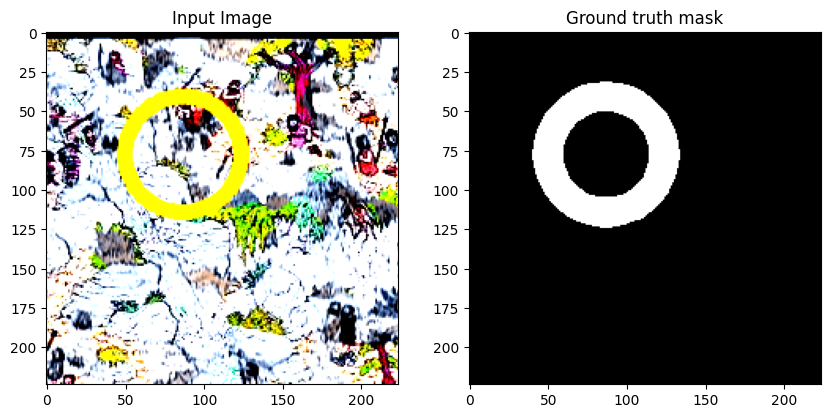

In [19]:
COUNT = 0
for j, (images,mask, labels) in enumerate(test_dl):
    if j > 10:        
        print(images.shape, labels)
        # images[mask == 1] += 1
        plt.figure(figsize=(10,5))
        plt.tight_layout()
        plt.subplot(1,2,1)
        plt.title("Input Image")
        plt.imshow(images[0].permute(1,2,0))
        plt.subplot(1,2,2)
        plt.title("Ground truth mask")
        plt.imshow(mask[0].permute(1,2,0))
        plt.show()
        break

In [21]:
from sklearn.metrics import roc_auc_score
def roc_auc(mask: torch.Tensor, attribution: torch.Tensor) -> float:
    mask = mask.detach().cpu().numpy()
    attribution = attribution.detach().cpu().numpy()

    if mask.shape != attribution.shape:
        raise ValueError(f"mask and attribution shape mismatch, {mask.shape} != {attribution.shape}")
    
    if len(mask.shape) != 4:
        raise ValueError(f"mask and attribution should have 4 dimensions, actual shape: {mask.shape}")
    
    if mask.shape[0] != 1 or mask.shape[1] != 1:
        raise ValueError(f"mask and attribution should have dimensions (1, 1, H, W), actual shape: {mask.shape}")
    
    # Check if batch dimension is present
    mask = mask.flatten()
    attribution = attribution.flatten()
    return roc_auc_score(mask, attribution)

Now we compare the ground truth attribution map (e.g. the binary mask) to the one created using various attribution methods.

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


torch.Size([1, 1, 7, 7])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


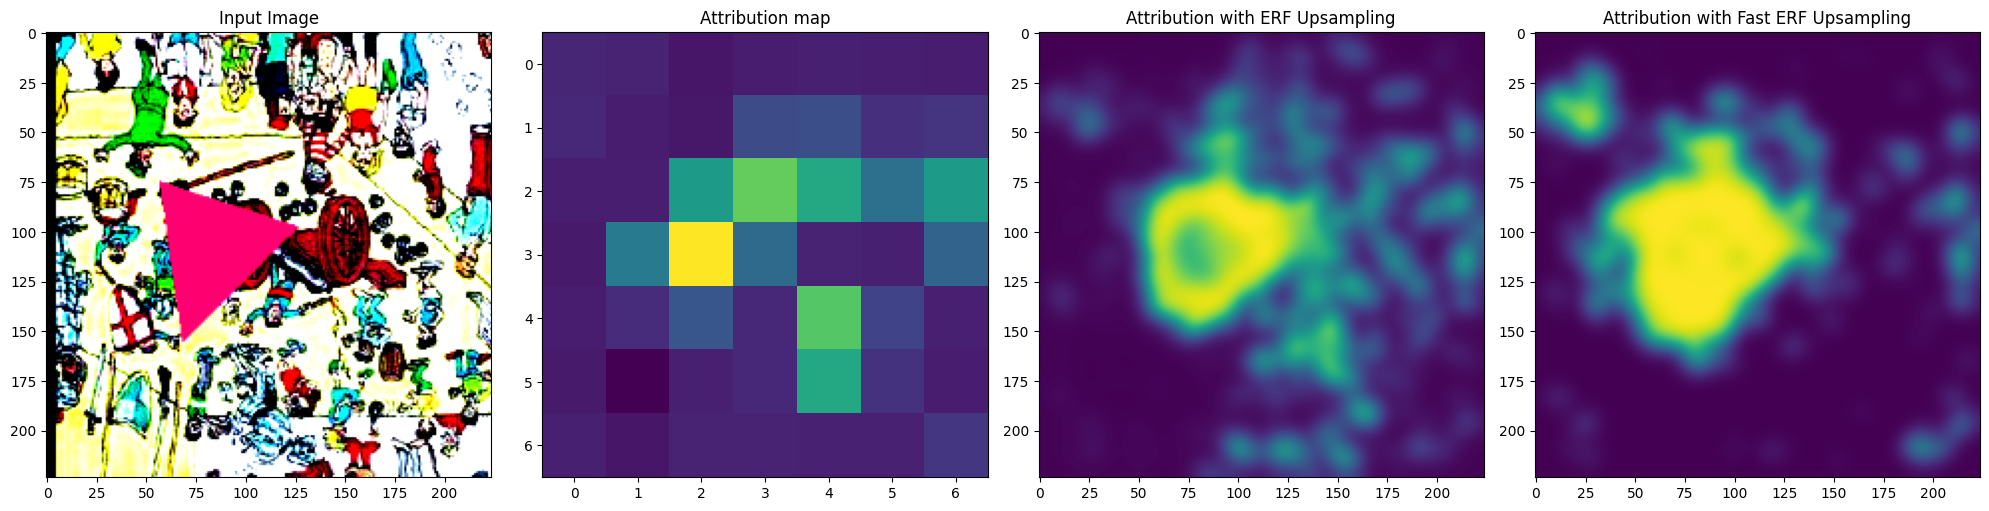

In [27]:
from utils import _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling, ERFUpsamplingFast, _DeepLiftShap

layer = model.features[-1]
# attribute_method = _GradCAMPlusPlus(model, layer)
attribute_method = _DeepLiftShap()
# bilinear_upsampler = SimpleUpsampling((224,224))
bilinear_upsampler = ERFUpsampling(model,layer, device)
erf_upsampler = ERFUpsamplingFast(model,layer, device)
INDEX = 9
for i, (images, masks, labels) in enumerate(test_dl):
    if i < INDEX:
        continue
    labels = labels.to(device).reshape(-1)
    images = images.to(device)

    attributions = attribute_method.attribute(
        input_tensor=images,
        model=model,
        layer=layer,
        target=labels,
        baseline_dist=baseline_dist,
    )
    print(attributions.shape)
    print(mask.shape)

    bilinear_map = bilinear_upsampler(attributions, images)
    erf_map = erf_upsampler(attributions, images)
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.title("Input Image")
    plt.imshow(images[0].permute(1,2,0))
    plt.subplot(1,4,2)
    plt.title("Attribution map")
    plt.imshow(attributions[0][0].detach().cpu().numpy())

    plt.subplot(1,4,3)
    plt.title("Attribution with ERF Upsampling")
    # plt.show()
    plt.imshow(bilinear_map[0][0].detach().cpu().numpy())
    plt.subplot(1,4,4)
    plt.title("Attribution with Fast ERF Upsampling")
    plt.imshow(erf_map[0][0].detach().cpu().numpy())
    # plt.subplot(1,5,5)
    # plt.title("Ground Truth")
    
    # plt.show()
    # plt.imshow(masks[0].permute(1,2,0))
    plt.tight_layout()
    plt.savefig(f"./plots/gradcam_{i}.pdf", format="pdf", dpi=600)
    plt.show()
    break



In [12]:
from results import ResultMetrics
results = ResultMetrics("./results.csv")

Results loaded from ./results.csv.


# Post-processing
We need to find the best post-processing method for the erf upsampled attribution maps.

In [26]:
from scipy.ndimage import gaussian_filter, median_filter
from itertools import product

def filter_clip_gaussian(attribution_map: torch.Tensor, percentile:int, sigma: float):
    attribution_map = attribution_map.detach().cpu().numpy()
    # Percetile: 0-100, top percentile to set to 1
    # Sigma: Gaussian filter sigma
    attribution_map = np.where(attribution_map > np.percentile(attribution_map, 100 - percentile), 1, attribution_map)
    attribution_map = gaussian_filter(attribution_map, sigma=sigma)

    return attribution_map

def filter_clip_median(attribution_map: torch.Tensor, percentile:int, size: int):
    attribution_map = attribution_map.detach().cpu().numpy()
    # Percetile: 0-100, top percentile to set to 1
    # Size: Median filter size
    attribution_map = np.where(attribution_map > np.percentile(attribution_map, 100 - percentile), 1, attribution_map)
    attribution_map = median_filter(attribution_map, size=size)

    return attribution_map

def filter_power_gaussian(attribution_map: torch.Tensor, sigma:float, power: float):
    attribution_map = attribution_map.detach().cpu().numpy()
    # Sigma: Gaussian filter sigma
    # Power: Power to raise the attribution map
    attribution_map = attribution_map ** power
    attribution_map = gaussian_filter(attribution_map, sigma=sigma)

    return attribution_map

# Define parameter ranges
param_grid = {
    "filter_clip_gaussian": {
        "percentile": [30, 20, 10],  # Example values
        "sigma": [2.0, 5.0, 10.0]
    },
    "filter_clip_median": {
        "percentile": [30, 20, 10],
        "size": [3, 5, 10]
    },
    "filter_power_gaussian": {
        "sigma": [2.0, 5.0, 10.0],
        "power": [1/3, 1/2, 2/3]
    }
}

# Generate all parameter combinations
def get_param_combinations(param_grid):
    all_combinations = []
    for filter_name, param_values in param_grid.items():
        keys, values = zip(*param_values.items())
        for combination in product(*values):
            all_combinations.append((filter_name, dict(zip(keys, combination))))
    return all_combinations

param_combinations = get_param_combinations(param_grid)
filter_results = {}


In [28]:
len(model.features)

21

In [ ]:
from utils import _GradCAMPlusPlus,_DeepLiftShap, SimpleUpsampling, ERFUpsampling
from tqdm.auto import tqdm

# for i in range(10, len(model.features)):
for i in [10, 15, 20]:
    layer = model.features[i]
    for attribute_method in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
        bilinear_upsampler = SimpleUpsampling((224,224))
        erf_upsampler = ERFUpsampling(model,layer, device)
        for i, (images, masks, labels) in tqdm(enumerate(test_dl)):
            labels = labels.to(device).reshape(-1)
            images = images.to(device)

            attributions = attribute_method.attribute(
                input_tensor=images,
                model=model,
                layer=layer,
                target=labels,
                baseline_dist=None,
            )
            masks = masks.sum(dim=1, keepdim=True)
            masks[masks > 0] = 1
            
            bilinear_map = bilinear_upsampler(attributions, images)
            erf_map = erf_upsampler(attributions, images)

            
            for filter_name, params in param_combinations:
                filter_func = globals()[filter_name]  # Get function by name
                processed_map = filter_func(attributions, **params)
                processed_roc_auc = roc_auc(masks, processed_map)
                if (filter_name, tuple(params.items())) not in filter_results:
                    filter_results[(filter_name, tuple(params.items()))] = [processed_roc_auc]
                else:
                    filter_results[(filter_name, tuple(params.items()))].append(processed_roc_auc)

            print(bilinear_map.shape,erf_map.shape, masks.shape)

            # results.add_result("VGG11", 
            #                 attribute_method.__class__.__name__, 
            #                 f"features.{i}",
            #                 "roc_auc",
            #                 bilinear_upsampler.__class__.__name__, 
            #                 roc_auc(masks, bilinear_map))
            # results.add_result("VGG11",
            #                     attribute_method.__class__.__name__,
            #                     f"features.{i}",
            #                     "recall",
            #                     erf_upsampler.__class__.__name__,
            #                     roc_auc(masks, erf_map))
    #         break
    #     break
    # break


0it [00:00, ?it/s]

Filtering:   0%|          | 0/27 [00:00<?, ?it/s]

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [ ]:
from metrics import calculate_metrics, ROC_AUC
from results import ResultMetrics
from utils import ERFUpsamplingFast

results = ResultMetrics("./results.csv")

for layer in model.features[10:]:
    for attribution in [_GradCAMPlusPlus(model, layer), _DeepLiftShap()]:
        for upsample in [ERFUpsamplingFast(model, layer, device)]:   
            calculate_metrics(model=model,
                            attribute_method=attribution,
                            test_dl=test_dl,
                            train_dl=train_dl,
                            layers=[layer],
                            metrics=[ROC_AUC()],
                            result_metrics=results,
                            upsample=upsample,
                            device=device,
                            model_name="VGG11",)
        